# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели ранжирования (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('data_init/retail_train.csv')
item_features = pd.read_csv('data_init/product.csv')
user_features = pd.read_csv('data_init/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [15]:
# Берем тестового юзера 2375

In [16]:
recommender.get_als_recommendations(2375, N=5)

[899624, 844179, 1044078, 871756, 1106523]

In [17]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [18]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 907099, 1133312]

In [19]:
recommender.get_similar_users_recommendation(2375, N=5)

[974265, 12523928, 10457044, 1124971, 1012801]

# Evaluate recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [20]:
ACTUAL_COL = 'actual'

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
# N = Neighbors
N_PREDICT = 50 

In [23]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

Wall time: 44 s


In [24]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[825665, 1007512, 9297615, 5577022, 10356272, ...","[1047619, 909497, 1062572, 885290, 841584, 828..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 916122, 6534480, 5569845, 844179, 65..."


In [25]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 0 ns


### Пример оборачивания

In [26]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [27]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [28]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [29]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

### Задание 1.

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

Пока пробуем отобрать 50 кандидатов (k=50)
Качество измеряем на data_val_matcher: следующие 6 недель после трейна
Дают ли own recommendtions + top-popular лучший recall?

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [30]:
TOPK_RECALL = 50

In [31]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04768043603353359),
 ('sim_item_rec', 0.033507635242834614)]

In [32]:
TOPK_RECALL = 20

In [33]:
a = sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

In [34]:
a

[('own_rec', 0.03928427679372909),
 ('als_rec', 0.029490903487410937),
 ('sim_item_rec', 0.017568542456292833)]

In [35]:
type(a[1])

tuple

In [36]:
from math import log

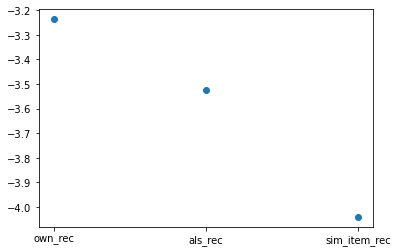

In [37]:
list_a = [(elem1, log(elem2)) for elem1, elem2 in a]
zip(*list_a)
plt.scatter(*zip(*list_a))
plt.show()

In [38]:
TOPK_RECALL_50 = 50

In [39]:
a_50 = sorted(calc_recall(result_eval_matcher, TOPK_RECALL_50), key=lambda x: x[1],reverse=True)

In [40]:
a_50

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04768043603353359),
 ('sim_item_rec', 0.033507635242834614)]

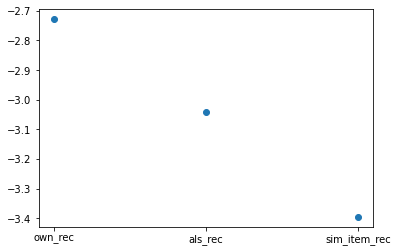

In [41]:
list_a_50 = [(elem1, log(elem2)) for elem1, elem2 in a_50]
zip(*list_a_50)
plt.scatter(*zip(*list_a_50))
plt.show()

k = {20, 50, 100, 200, 500}

In [42]:
TOPK_RECALL_100 = 100

In [43]:
a_100 = sorted(calc_recall(result_eval_matcher, TOPK_RECALL_100), key=lambda x: x[1],reverse=True)

In [44]:
a_100

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04768043603353359),
 ('sim_item_rec', 0.033507635242834614)]

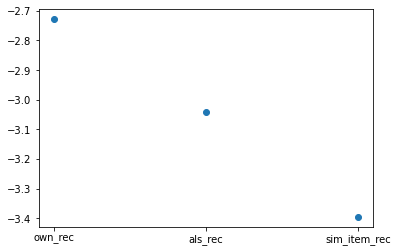

In [45]:
list_a_100 = [(elem1, log(elem2)) for elem1, elem2 in a_100]
zip(*list_a_100)
plt.scatter(*zip(*list_a_100))
plt.show()

In [46]:
TOPK_RECALL_200 = 200

In [47]:
a_200 = sorted(calc_recall(result_eval_matcher, TOPK_RECALL_200), key=lambda x: x[1],reverse=True)

In [48]:
a_200

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04768043603353359),
 ('sim_item_rec', 0.033507635242834614)]

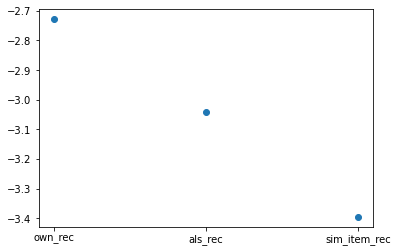

In [49]:
list_a_200 = [(elem1, log(elem2)) for elem1, elem2 in a_200]
zip(*list_a_200)
plt.scatter(*zip(*list_a_200))
plt.show()

лучше брать k больше 50

### Precision@5 of matching

In [50]:
TOPK_PRECISION = 5

In [51]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.12226871222687016),
 ('sim_item_rec', 0.06211064621106495)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- *Для примера* сгенерируем топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [52]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [53]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [54]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [55]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [56]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [57]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [58]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [59]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [60]:
# dask dataframe

df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [61]:
df_ranker_train.target.value_counts()

0.0    99669
1.0    11644
Name: target, dtype: int64

In [62]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [63]:
df_ranker_train['target'].mean()

0.10460593102333061

## Подготавливаем фичи для обучения модели

In [64]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [65]:
reat_feat = pd.read_csv('data/retail_train.csv')

In [66]:
reat_feat.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [67]:
reat_feat_2 = reat_feat.groupby(['item_id'])['user_id'].count().reset_index(name='counts')

In [68]:
reat_feat_2.head(2)

,item_id,counts
0,25671,3
1,26081,1


In [69]:
reat_feat_3 = reat_feat.groupby(['user_id', 'item_id'])['sales_value'].sum().reset_index(name='sum_good')

In [70]:
reat_feat_3.head()

,user_id,item_id,sum_good
0,1,819312,5.67
1,1,820165,3.50
2,1,821815,3.38
3,1,821867,0.69
4,1,823721,2.99


In [71]:
reat_feat_f = reat_feat_2.merge(reat_feat_3, on='item_id', how='left')

In [72]:
reat_feat_f.head(2)

,item_id,counts,user_id,sum_good
0,25671,3,325,13.96
1,25671,3,358,3.49


In [91]:
#reat_feat = reat_feat.merge(reat_feat_2, on='item_id', how='inner')
#reat_feat = reat_feat.join(reat_feat_2)#, on='item_id', how='left')
#reat_feat = reat_feat.join(reat_feat_2.set_index('counts'), on='item_id', suffix = '_n')

In [93]:
#reat_feat_3 = reat_feat.groupby(['user_id', 'week_no'])['sales_value'].sum().reset_index(name='sums_a_week')

In [77]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,0,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,0,2,None/Unknown,7


In [73]:
user_features['marital_status_code'].value_counts()

U    344
A    340
B    117
Name: marital_status_code, dtype: int64

In [74]:
user_features['hh_comp_desc'].value_counts()

2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: hh_comp_desc, dtype: int64

In [76]:
user_features['hh_comp_desc'] = user_features['hh_comp_desc']\
.replace({'2 Adults No Kids':0, '2 Adults Kids':1, 'Single Female':2, 'Single Male':2, 'Unknown':2, '1 Adult Kids':1 })

In [80]:
bin_names = ['user_id', 'hh_comp_desc']

user_features_2 = user_features[bin_names]

In [82]:
user_features_2.head()

,user_id,hh_comp_desc
0,1,0
1,7,0
2,8,1
3,13,1
4,16,2


In [83]:
reat_feat_f = reat_feat_f.merge(user_features_2, on='user_id', how='left')

In [86]:
reat_feat_f.head()

,item_id,counts,user_id,sum_good,hh_comp_desc
0,25671,3,325,13.96,1.0
1,25671,3,358,3.49,0.0
2,25671,3,1228,3.49,2.0
3,26081,1,1675,0.99,NaN
4,26093,1,1032,1.59,NaN


In [94]:
reat_feat_fin = reat_feat_f.loc[reat_feat_f['hh_comp_desc'] == 'NaN', 'hh_comp_desc'] = reat_feat_f['hh_comp_desc'].mode()

In [95]:
reat_feat_fin.head()

0    2.0
dtype: float64

In [96]:
reat_feat_f['hh_comp_desc'].fillna(2, inplace=True)

In [97]:
reat_feat_f.head()

,item_id,counts,user_id,sum_good,hh_comp_desc
0,25671,3,325,13.96,1.0
1,25671,3,358,3.49,0.0
2,25671,3,1228,3.49,2.0
3,26081,1,1675,0.99,2.0
4,26093,1,1032,1.59,2.0


In [98]:
df_ranker_train = df_ranker_train.merge(reat_feat_f, on='item_id', how='left')

In [77]:
#df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')

In [99]:
#df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
#df_ranker_train = df_ranker_train.merge(reat_feat, on='item_id', how='left')
#df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id_x,item_id,target,counts,user_id_y,sum_good,hh_comp_desc
0,2070,1105426,0.0,103,79,3.99,2.0
1,2070,1105426,0.0,103,85,31.92,2.0


In [ ]:
#df_ranker_train

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [ ]:
#df_ranker_train.head()

In [100]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [101]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['counts', 'user_id_y', 'sum_good', 'hh_comp_desc']

## Обучение модели ранжирования

In [102]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\sheno\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\sheno\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [103]:
df_ranker_predict = df_ranker_train.copy()

In [104]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [105]:
df_ranker_predict

,user_id_x,item_id,target,counts,user_id_y,sum_good,hh_comp_desc,proba_item_purchase
0,2070,1105426,0.0,103,79,3.99,2.0,0.082453
1,2070,1105426,0.0,103,85,31.92,2.0,0.082453
2,2070,1105426,0.0,103,198,3.99,1.0,0.082453
3,2070,1105426,0.0,103,322,7.98,2.0,0.082453
4,2070,1105426,0.0,103,376,3.99,2.0,0.082453
...,...,...,...,...,...,...,...,...
16883602,1745,1024051,0.0,249,2412,7.50,2.0,0.149291
16883603,1745,1024051,0.0,249,2415,5.00,2.0,0.149291
16883604,1745,1024051,0.0,249,2423,3.19,2.0,0.149291
16883605,1745,1024051,0.0,249,2468,2.50,2.0,0.149291


## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [106]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [107]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 8.31 s


In [108]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [112]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [116]:
user_id = result_eval_ranker['user_id']

In [117]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

KeyError: 'user_id'

In [118]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.1444117647058813)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?